### Scikit-Learn, Regression, and PCA, and still more regression.

In [1]:
"""   
helper python script that contains all functions 
referenced in this ipynb.
"""
%run lab4.py

In [16]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd

%precision %.2f
%matplotlib inline

from matplotlib import rcParams
import matplotlib as mpl

from matplotlib.rcsetup import cycler

mpl.rc('figure', figsize=(10,6), dpi=150)
mpl.rc('axes', facecolor='white', 
       prop_cycle=cycler('color', dark2_colors ))
mpl.rc('lines', lw=2)
mpl.rc('patch', ec='white', fc=dark2_colors[0])
mpl.rc('font', size=14, family='StixGeneral')


All objects within **scikit-learn** share a uniform common basic API consisting of three complementary interfaces: 
- an `estimator` interface for building and ﬁtting models, 
- a `predictor` interface for making predictions and 
- a `transformer` interface for converting data.


1. The **estimator** interface is at the core of the library. It deﬁnes instantiation mechanisms of objects and exposes a `fit` method for learning a model from training data. Machine learning tasks like `feature extraction`, `feature selection` or `dimensionality reduction` are also provided as `estimators`.

```
clf = LogisticRegression()
clf.fit(X_train, y_train)

```
2. The **predictor** interface extends the notion of an estimator by adding a `predict` method that takes an array `X_test` and produces predictions for `X_test`, based on the learned parameters of the estimator.

```
clf.predict(X_test)
```

3. To modify or ﬁlter data before feeding it to a learning algorithm, some estimators in the library implement a **transformer** interface which deﬁnes a `transform` method. It takes as input some new data `X_test` and yields as output `a transformed version of X_test`. `Preprocessing, feature selection, feature extraction and dimensionality reduction` algorithms are all provided as transformers within the library. This is usually done via the `fit_transform` method. 

```
pca = RandomizedPCA(n_components=2)
train_x = pca.fit_transform(train_x)
test_x = pca.transform(test_x)`
```

> The training set here is "fit" to find the PC components, and then transformed. Since `pca.fit()` by itself changes the pca object, if we want to transform other data using the same transformation we simply call `transform` subsequently.

Finally, there is the concept of a `meta-estimator`, which behaves quite similarly to standard estimators, but allows us to wrap, for example, `cross-validation`, or methods that build and combine simpler models or schemes.

```
from sklearn.multiclass import OneVsOneClassifier
clf=OneVsOneClassifier(LogisticRegression())
```

> In scikit-learn, model selection is supported in two distinct meta-estimators, `GridSearchCV` and `RandomizedSearchCV`. They take as input an estimator (basic or composite), whose hyper-parameters must be optimized, and a set of hyperparameter settings to search through.

> Most machine learning algorithms implemented in **scikit-learn** expect data to be stored in a `two-dimensional array or matrix`. The arrays can be either numpy arrays, or in some cases scipy.sparse matrices. The size of the array is expected to be `[n_samples, n_features]`.

### PART 1: Linear Regression with a touch of PCA.

In [3]:
census_data = pd.read_csv("./data/census_demographics.csv")
census_data.head()

,state,per_black,per_hisp,per_white,educ_hs,educ_coll,average_income,median_income,pop_density,vote_pop,older_pop,per_older,per_vote
0,ALABAMA,26.5,4.0,66.8,81.4,21.7,22984,42081,94.4,3.001712e+06,672383.600,0.140,0.625
1,ALASKA,3.6,5.8,63.7,90.7,27.0,30726,66521,1.2,4.755484e+05,58540.158,0.081,0.658
2,ARIZONA,4.5,30.1,57.4,85.0,26.3,25680,50448,56.3,3.934881e+06,920515.710,0.142,0.607
3,ARKANSAS,15.6,6.6,74.2,81.9,19.1,21274,39267,56.0,1.798043e+06,428944.934,0.146,0.612
4,CALIFORNIA,6.6,38.1,39.7,80.7,30.1,29188,60883,239.1,2.400975e+07,4409953.704,0.117,0.637


#### Clean the data set, and have it indexed by the state abbrev.

In [6]:
# CAPITALS turned to Titlecase
census_data.state = census_data.state.str.title()
census_data.state = census_data.state.str.replace("Of", "of")
# use abbreviations
census_data['state']=census_data['state'].replace(abbrev_states_dict)
# rename column
census_data.rename(columns={'state':'State'}, inplace=True)
# set index
census_data.set_index("State", inplace=True)
census_data.head()

,per_black,per_hisp,per_white,educ_hs,educ_coll,average_income,median_income,pop_density,vote_pop,older_pop,per_older,per_vote
State,,,,,,,,,,,,
AL,26.5,4.0,66.8,81.4,21.7,22984,42081,94.4,3.001712e+06,672383.600,0.140,0.625
AK,3.6,5.8,63.7,90.7,27.0,30726,66521,1.2,4.755484e+05,58540.158,0.081,0.658
AZ,4.5,30.1,57.4,85.0,26.3,25680,50448,56.3,3.934881e+06,920515.710,0.142,0.607
AR,15.6,6.6,74.2,81.9,19.1,21274,39267,56.0,1.798043e+06,428944.934,0.146,0.612
CA,6.6,38.1,39.7,80.7,30.1,29188,60883,239.1,2.400975e+07,4409953.704,0.117,0.637


In [7]:
# select a subset of features
choice = census_data[['educ_coll', 'average_income', 'per_vote']]

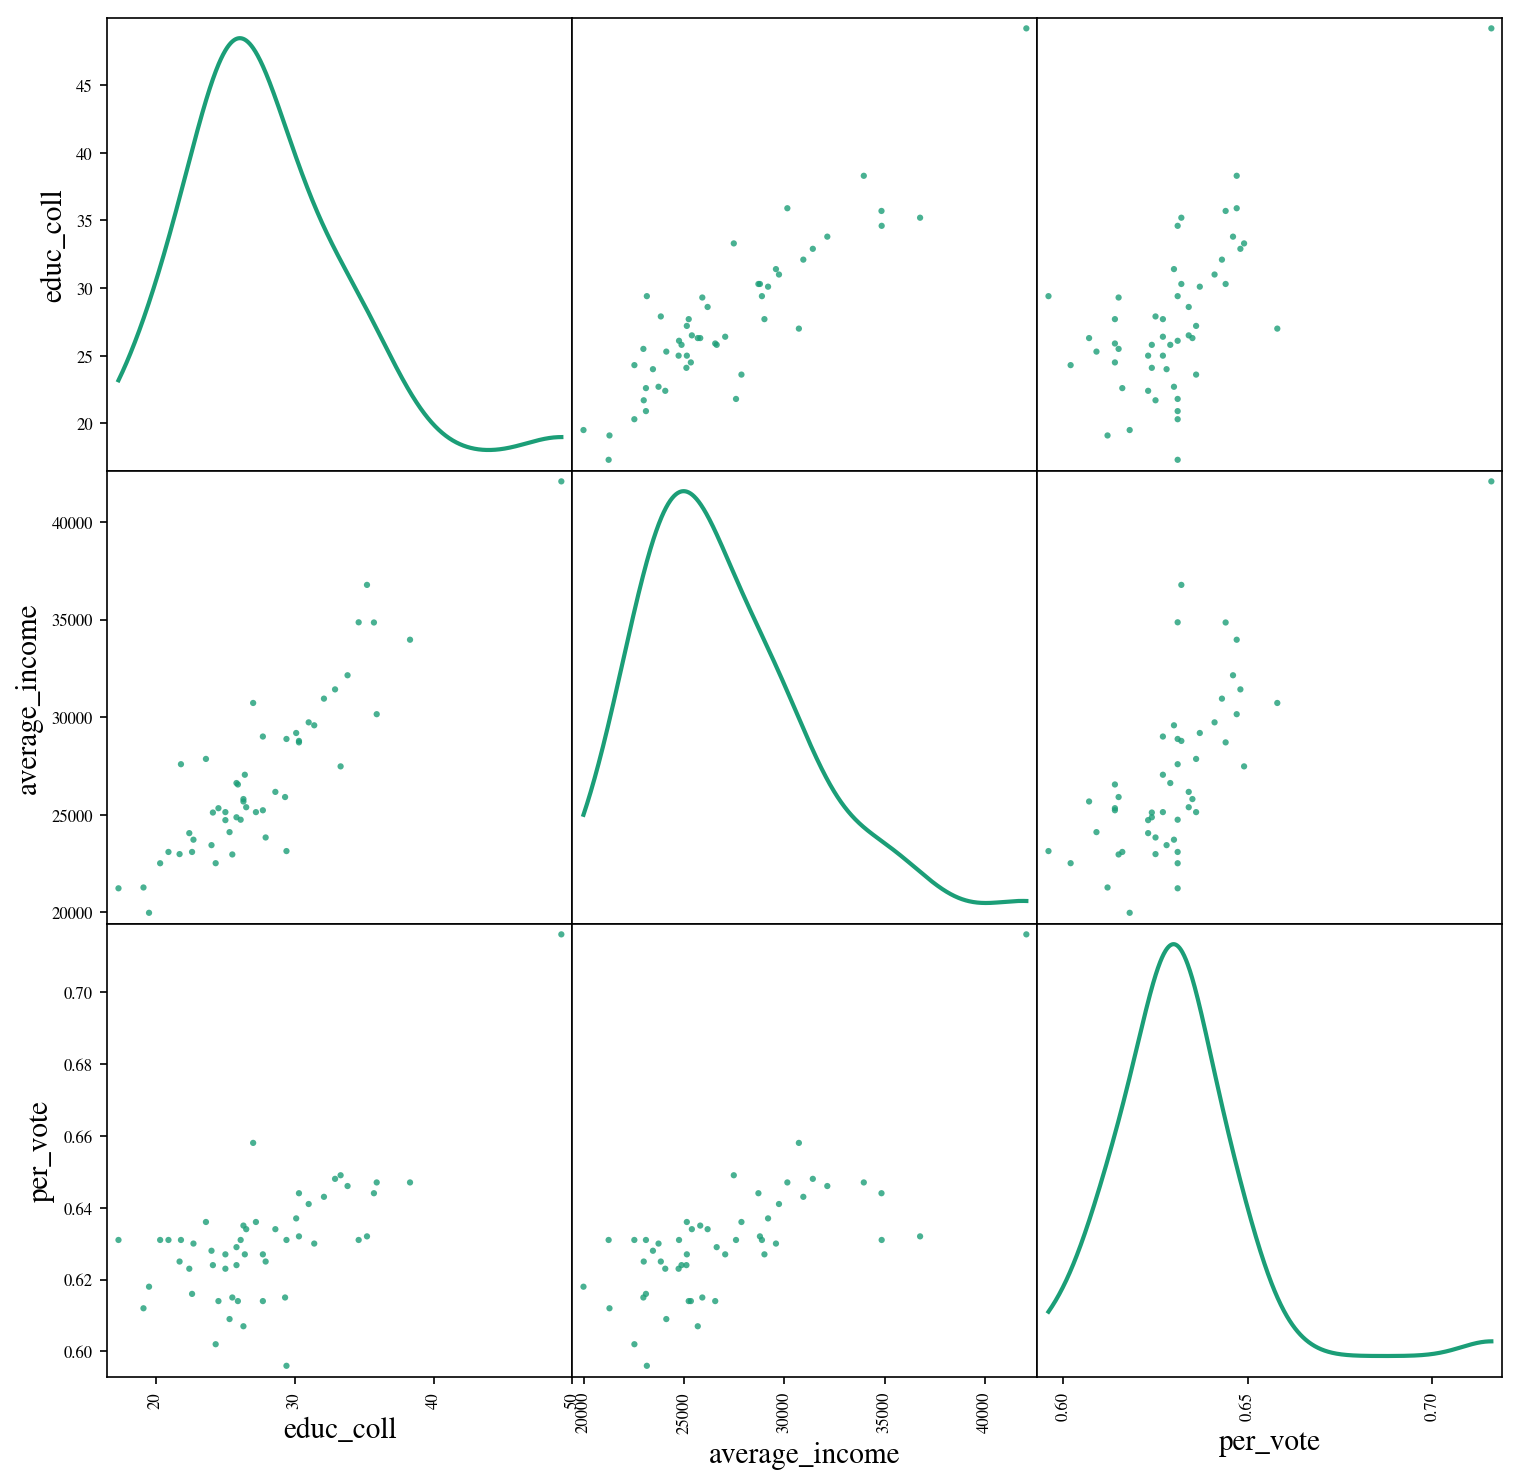

In [9]:
# use a SPLOM to visualize some columns of this dataset. 
# In pandas,  SPLOM aka scatter-matrix.
from pandas.plotting import scatter_matrix

axeslist=scatter_matrix(choice, alpha=0.8, 
                        figsize=(12, 12), diagonal="kde")

for ax in axeslist.flatten():
    ax.grid(False)

> `average_income` seems to have a strong correlation with `educ_coll`.

We posit that the average income is higher in states which have "better" education systems and send more students to college. We confirm our intuition by seeing the `correlations`.

In [10]:
choice.corr()

,educ_coll,average_income,per_vote
educ_coll,1.000000,0.894066,0.670977
average_income,0.894066,1.000000,0.732703
per_vote,0.670977,0.732703,1.000000


We carry out the regression, first standardizing our variables.
We store both an `_vec variable`, which is easier to plot with, as well as the reshaped variable.

In [9]:
from sklearn.linear_model import LinearRegression
X_norm = (choice - choice.mean(axis=0))/ choice.std(axis=0)
X_norm.head()

,educ_coll,average_income,per_vote
State,,,
AL,-1.044627,-0.923748,-0.305171
AK,-0.104358,0.864526,1.562478
AZ,-0.228545,-0.301017,-1.323889
AR,-1.505890,-1.318730,-1.040912
CA,0.445610,0.509273,0.373974


We split the data into a training set and a testing set. By default, 25% of the data is reserved for testing. This is the first of multiple ways that we will see to do this.

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_norm[['educ_coll']], 
                                                    X_norm.average_income)

We use the training set for the fit, and find what our predictions ought to be on both the training and test set.

In [24]:
clf1 = LinearRegression()
# fit model
clf1.fit(X_train, y_train)
# predict train & test
predicted_train = clf1.predict(X_train)
predicted_test = clf1.predict(X_test)
print(clf1.coef_, clf1.intercept_)

[0.91657907] -0.0031108376693320186


We plot the scatter against the fit for both training and test data.

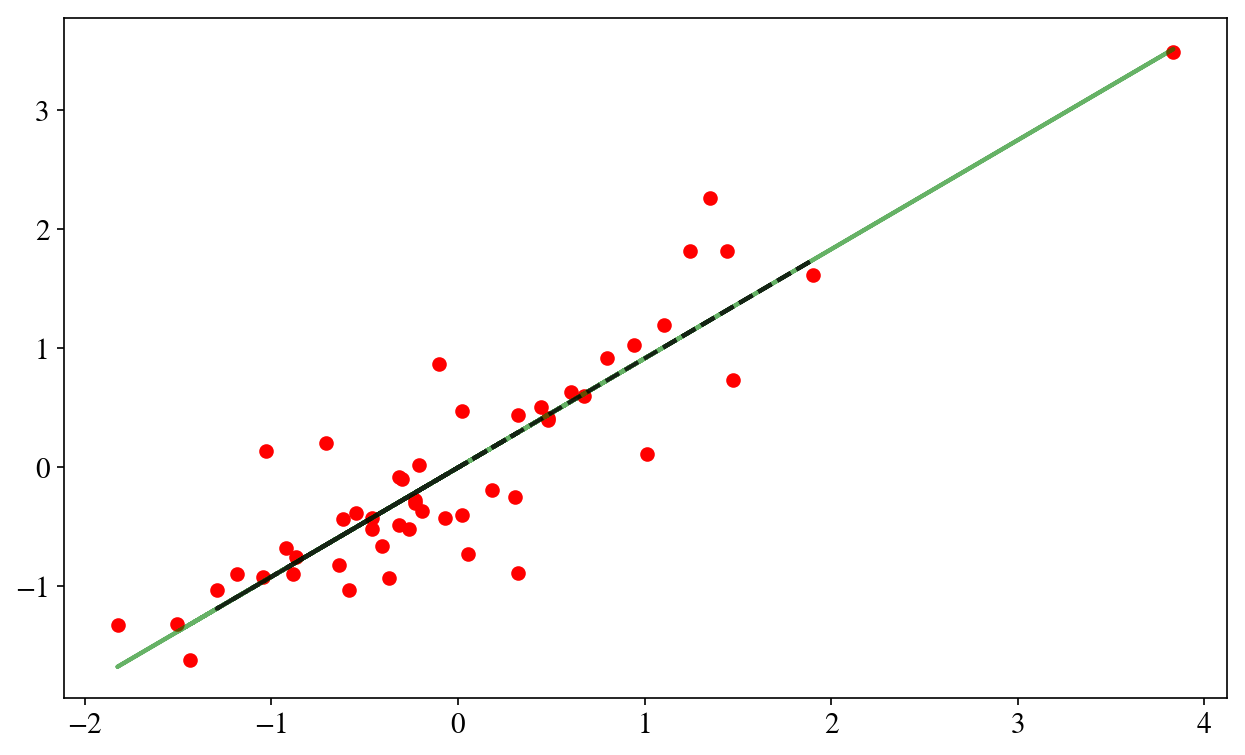

In [33]:
plt.scatter(X_norm.educ_coll, X_norm.average_income,c='r')
plt.plot(X_train, predicted_train, c='g', alpha=0.6)
plt.plot(X_test, predicted_test, '--k', alpha=0.8)

We then look at the residuals, again on both sets.

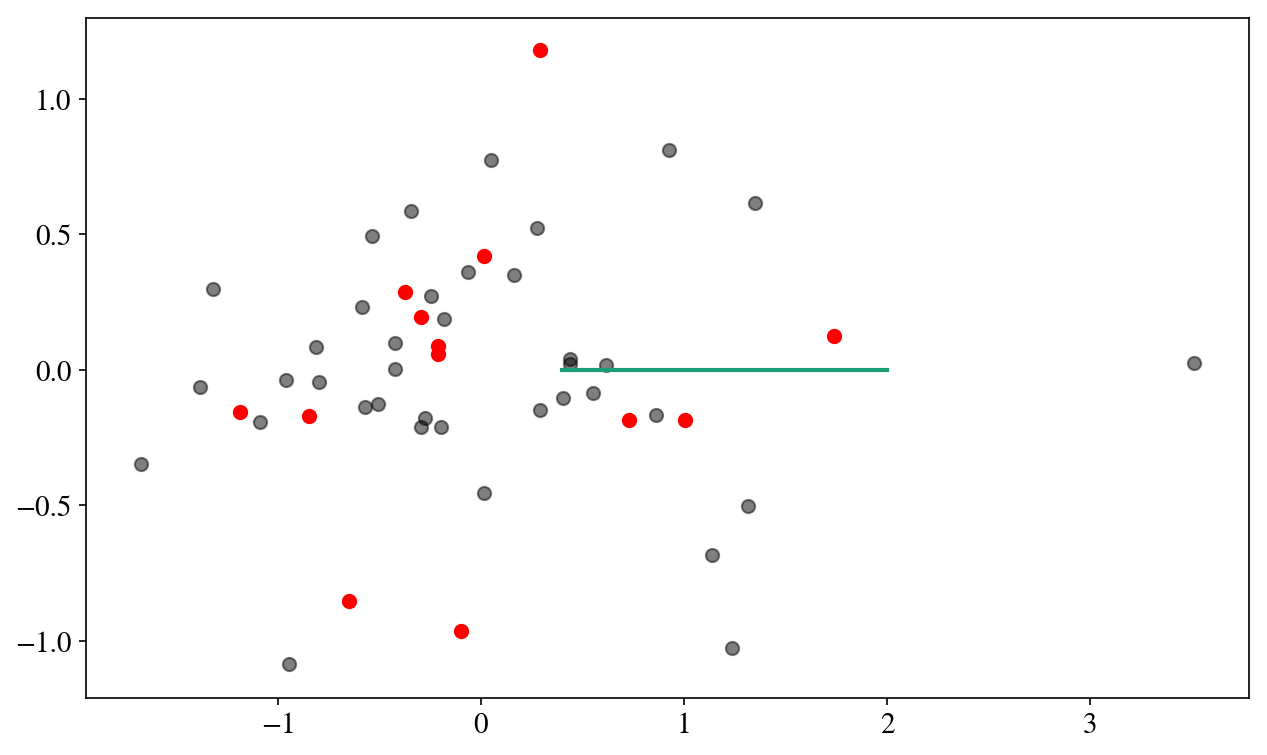

In [35]:
plt.scatter(predicted_test, predicted_test- y_test, c='r', s=40)
plt.scatter(predicted_train, predicted_train- y_train, c='k', s=40, alpha=0.5)
plt.plot([0.4,2],[0,0])



We ask scikit-learn to spit out the $R^2$.

In [38]:
clf1.score(X_train, y_train), clf1.score(X_test, y_test)

(0.8400644272035934, 0.6101931392409485)

### Doing a PCA on the data

Lets take the standarddized data and do a 2-D PCA on it. Here we do not seek to accomplish a dimensional reduction, but to understand the variance structure of the data.

In [42]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X = pca.fit_transform(X_norm)
pca.explained_variance_ratio_

array([0.85, 0.12])

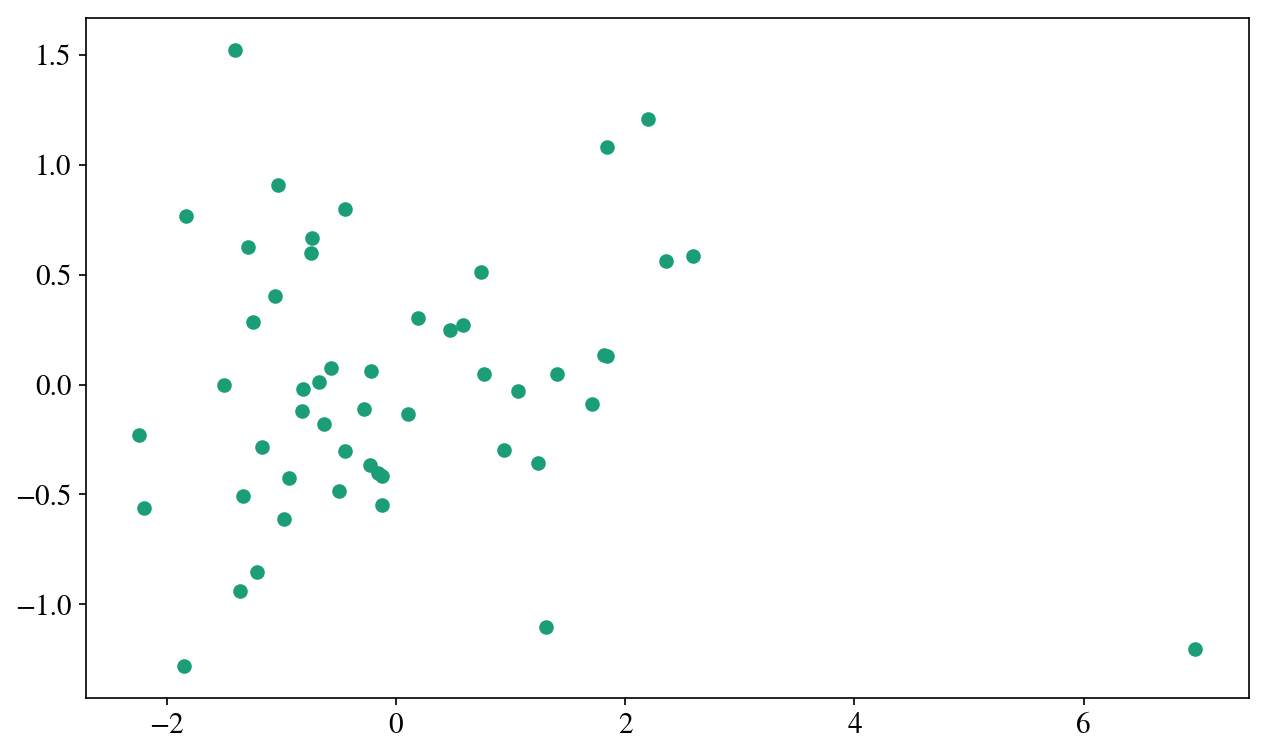

In [43]:
plt.scatter(X[:,0], X[:,1])

Since the first component is so large, lets only keep it, and then reconstruct the original data from only this component, setting the others to 0.

In [44]:
pca1 = PCA(n_components=1) # only keep one dimension!
X_E = pca1.fit_transform(X_norm)
X_reconstructed = pca1.inverse_transform(X_E)

We plot the reconstructed education(x) and income(y) from the first principal component, in blue.

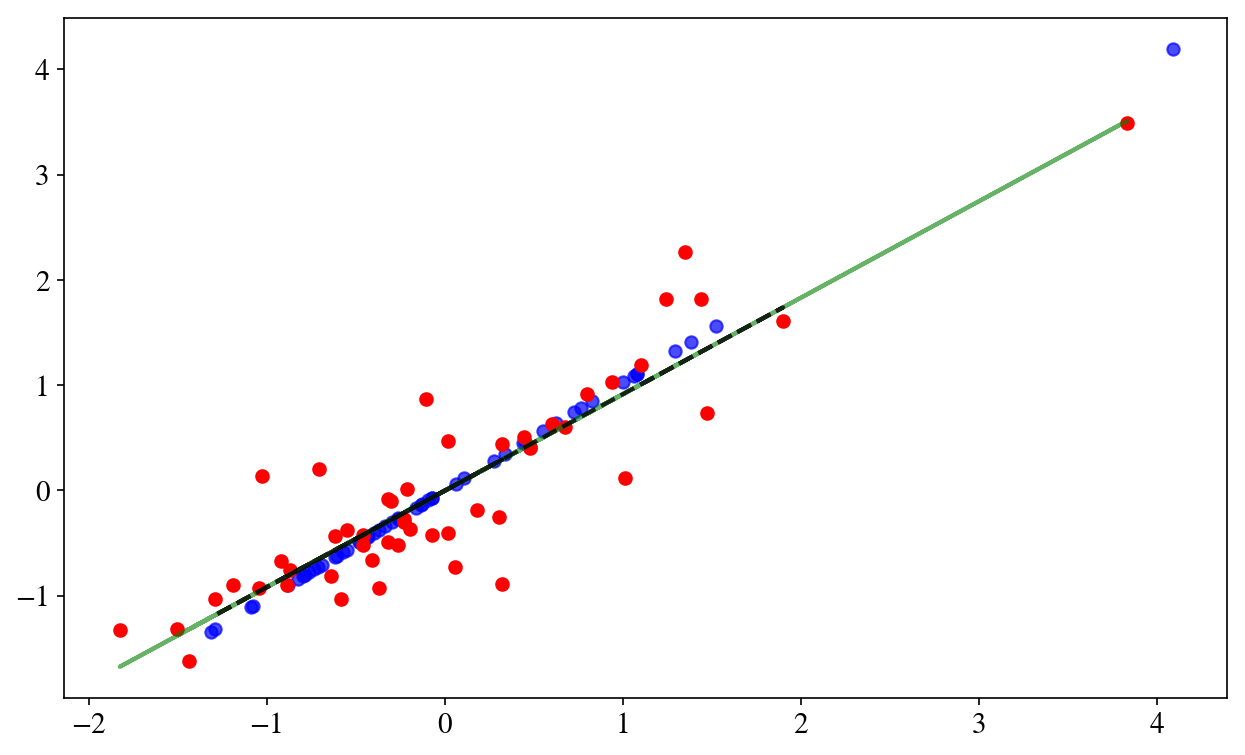

In [45]:
plt.scatter(X_reconstructed[:,0], X_reconstructed[:,1],c='b', s=35, alpha=0.7)
plt.scatter(X_norm.educ_coll, X_norm.average_income,c='r')
plt.plot(X_train, predicted_train, c='g', alpha=0.6)
plt.plot(X_test, predicted_test, '--k', alpha=0.8)

---

### Part 2 : Logistic Regression

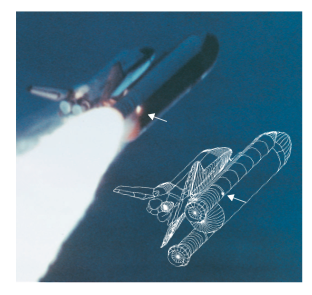

In [47]:
from IPython.display import Image
Image('./data/shuttle.png')

On January 28, 1986, the space shuttle Challenger exploded and seven astronauts died because two rubber O-rings due to the low ambient temperatures ; these were in the low 30s and the O-rings themselves were much colder, less than 20F.

In [4]:
# data on previous failures of the O-rings at various temperatures.
data=np.array([[float(j) for j in e.strip().split()] for e in open("./data/chall.txt")])
# split the data into meaningful columns
temps, pfail = data[:,0], data[:,1]
data[:5]

array([[66.,  0.],
       [70.,  1.],
       [69.,  0.],
       [68.,  0.],
       [67.,  0.]])

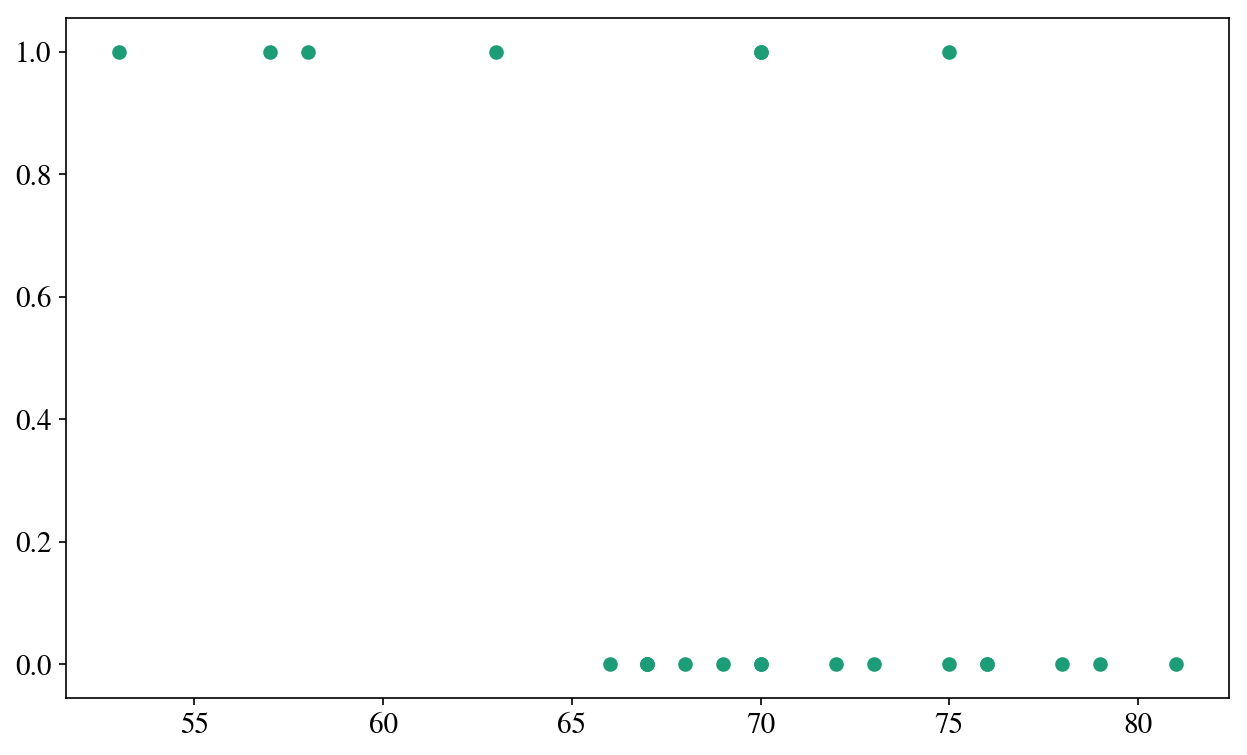

In [5]:
# plot the data
plt.scatter(temps, pfail)

1 represents failure. This graph has a classic `sigmoid` shape, so one might expect logistic regression to work.

Logistic regression pipeline resembles the linear, but for setting the regularization co-efficient `C` (default=1). 

The meaning of C is: 

- the larger the C, the lesser the regularization, which allows the co-efficients to range widely.
 
- The smaller the C,  the higher the regularization, the higher the penalty on the values of regression coefficients. 

**Scikit-learn** bakes in two penalties: 
- a `l2` penalty which penalizes the sum of the squares of the coefficients, and 
- a `l1` penalty which penalizes the sum of the absolute values.

Usually, there are many co-variates we use for our prediction: we want to make sure we can get away with the simplest model that describes our data, even if that might increase the bias side of the bias-variance tradeoff a bit.

we have just two co-efficents: an intercept, and the outside temperature. So we do not expect to need regularization much. Indeed lets set `C=1000`.

In [22]:
from sklearn.linear_model import LogisticRegression
reg=1000
clf4 = LogisticRegression(C=reg, solver='liblinear')
clf4.fit(temps.reshape(-1,1), pfail)

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [23]:
# create new temp data set to expose the model variance
tempsnew=np.linspace(20., 90., 15)
# collect prbabilities for failure
probs = clf4.predict_proba(tempsnew.reshape(-1,1))[:, 1]
# collect predictions for failure
predicts = clf4.predict(tempsnew.reshape(-1,1))

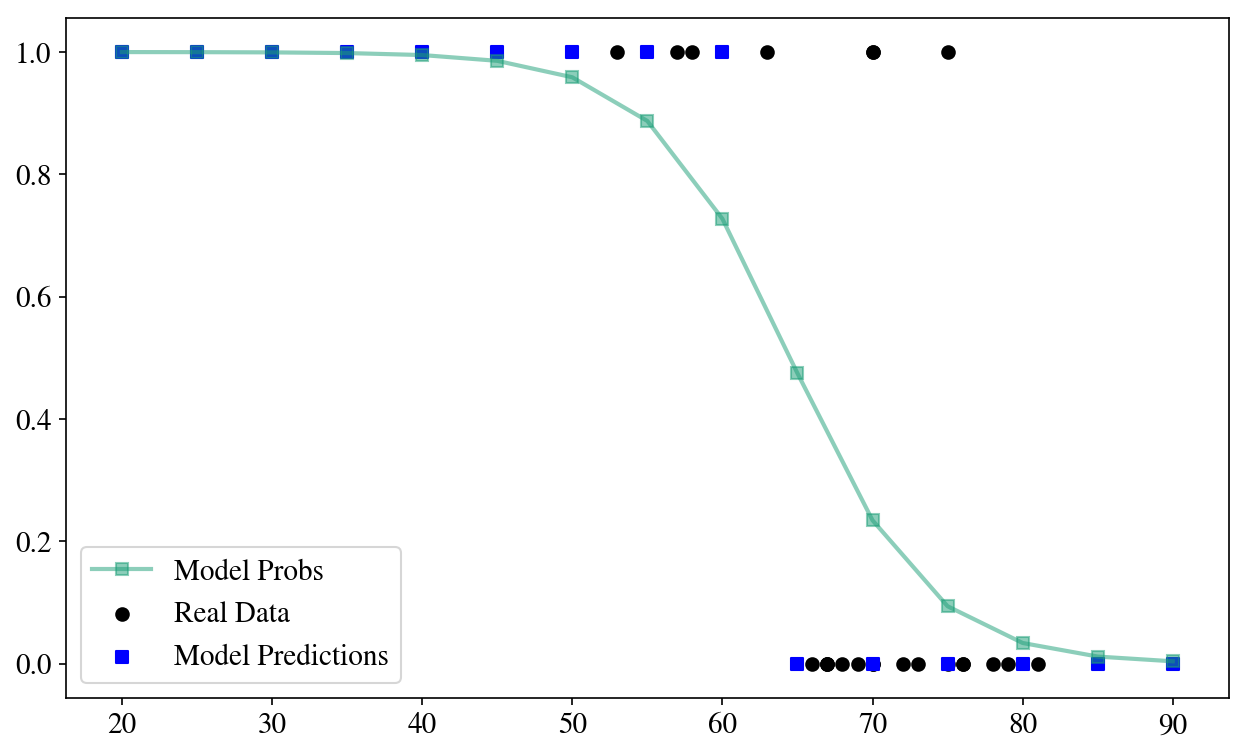

In [25]:
# plot data & our predictions
plt.scatter(temps, pfail, color='k', label='Real Data')

plt.plot(tempsnew, probs, 
         marker='s', alpha=0.5, 
         label='Model Probs')

plt.scatter(tempsnew, predicts, 
            marker='s', color="b", 
            label='Model Predictions')

plt.legend(loc='lower left')

We use `pd.crosstab` to write a table of prediction vs failure on the "training" set. As one might expect, the mislabellings come at the higher temperatures.

In [27]:
pd.crosstab(pfail, clf4.predict(temps.reshape(-1,1)), 
            rownames=["Actual"], colnames=["Predicted"])

Predicted,0.0,1.0
Actual,,
0.0,16,0
1.0,3,4


***Logistic Regression with scikit-learn's default value for `C`. 
Make a plot similar to the scatterplot above, and carry out the cross-tabulation. What happens?***

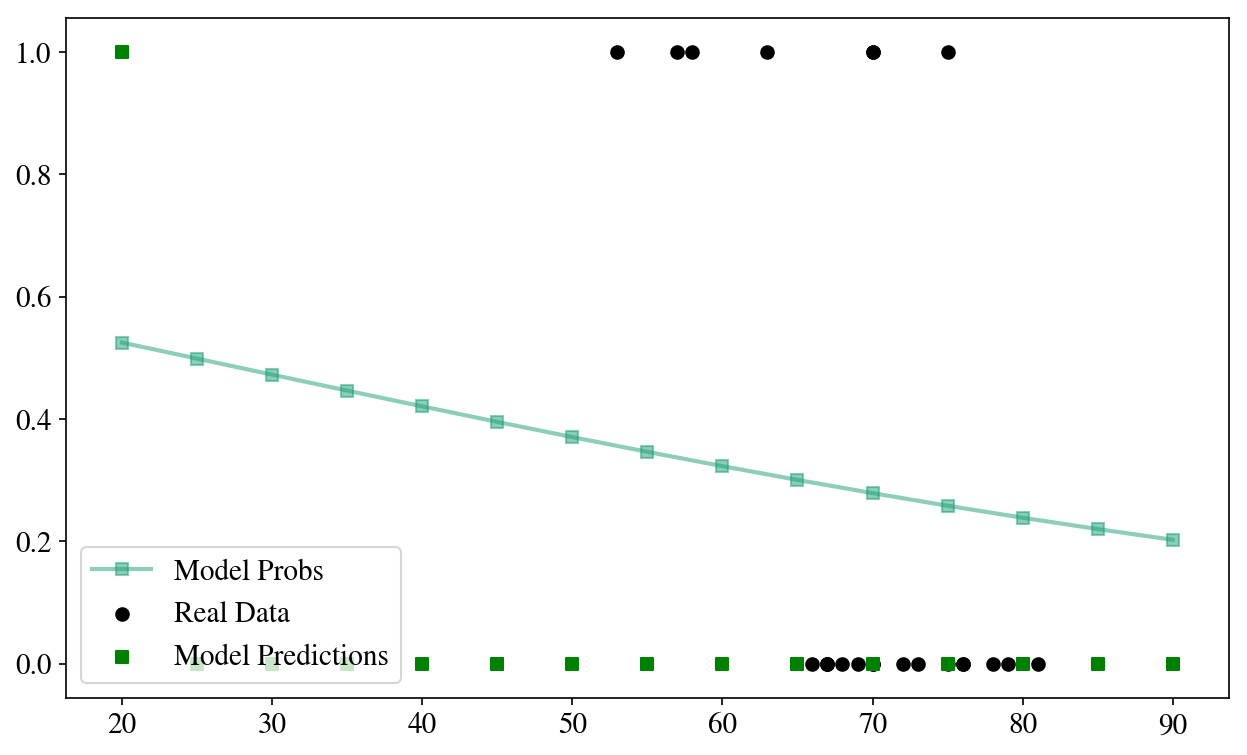

In [21]:
from sklearn.linear_model import LogisticRegression
reg=1
clf4w = LogisticRegression(C=reg, solver='liblinear')
clf4w.fit(temps.reshape(-1,1), pfail)

# create new temp data set to expose the model variance
tempsnew=np.linspace(20., 90., 15)
# collect prbabilities for failure
probs = clf4w.predict_proba(tempsnew.reshape(-1,1))[:, 1]
# collect predictions for failure
predicts = clf4w.predict(tempsnew.reshape(-1,1))

# plot data & our predictions
plt.scatter(temps, pfail, color='k', label='Real Data')
plt.plot(tempsnew, probs, 
         marker='s', alpha=0.5, label='Model Probs')
plt.scatter(tempsnew, predicts, 
            marker='s', color="green", label='Model Predictions')
plt.legend(loc='lower left')

In [30]:
pd.crosstab(pfail, clf4w.predict(temps.reshape(-1,1)), 
            rownames=["Actual"], colnames=["Predicted"])

Predicted,0.0
Actual,
0.0,16
1.0,7


---

### Logistic Regression with cross-validation

We now actually go ahead and to the train/test split. Not once but multiple times, on a grid search, for different values of `C`. For each `C`, we:

- create `n_folds` folds. Since the data size is 23 here, and we have 5 folds, we roughly split the data into 5 folds of 4-5 values each, randomly.
- We then `train on 4 of these folds, test on the 5th`.
- We average the results of all such combinations
- We move on to the next value of C, and find `the optimal value that minimizes mean square error (MSE)`.
- We finally use that value to make the final fit.

Check the structure of the GridSearchCV estimator in `cv_optimize`.

In [6]:
from sklearn.linear_model import LogisticRegression

def fit_logistic(X_train, y_train, 
                 reg=0.0001, penalty="l2"):
    clf = LogisticRegression(C=reg, penalty=penalty, solver='liblinear')
    clf.fit(X_train, y_train)
    return clf

from sklearn.model_selection import GridSearchCV

def cv_optimize(X_train, y_train, 
                paramslist, penalty="l2", 
                n_folds=10):
    clf = LogisticRegression(penalty=penalty, solver='liblinear')
    parameters = {"C": paramslist}
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(X_train, y_train)
    return gs.best_params_, gs.best_score_

def cv_and_fit(X_train, y_train, 
               paramslist, penalty="l2", 
               n_folds=5):
    bp, bs = cv_optimize(X_train, y_train, 
                         paramslist, penalty=penalty, 
                         n_folds=n_folds)
    print("BestParams | BestScore : {} | {}".format(bp, bs))
    
    clf = fit_logistic(X_train, y_train, 
                       penalty=penalty, reg=bp['C'])
    return clf

In [17]:
clf=cv_and_fit(temps.reshape(-1,1), pfail, np.logspace(-1, 4, num=100))

BestParams | BestScore : {'C': 1232.8467394420659} | 0.8695652173913043


In [18]:
pd.crosstab(pfail, clf.predict(temps.reshape(-1,1)), 
            rownames=["Actual"], colnames=["Predicted"])

Predicted,0.0,1.0
Actual,,
0.0,16,0
1.0,3,4


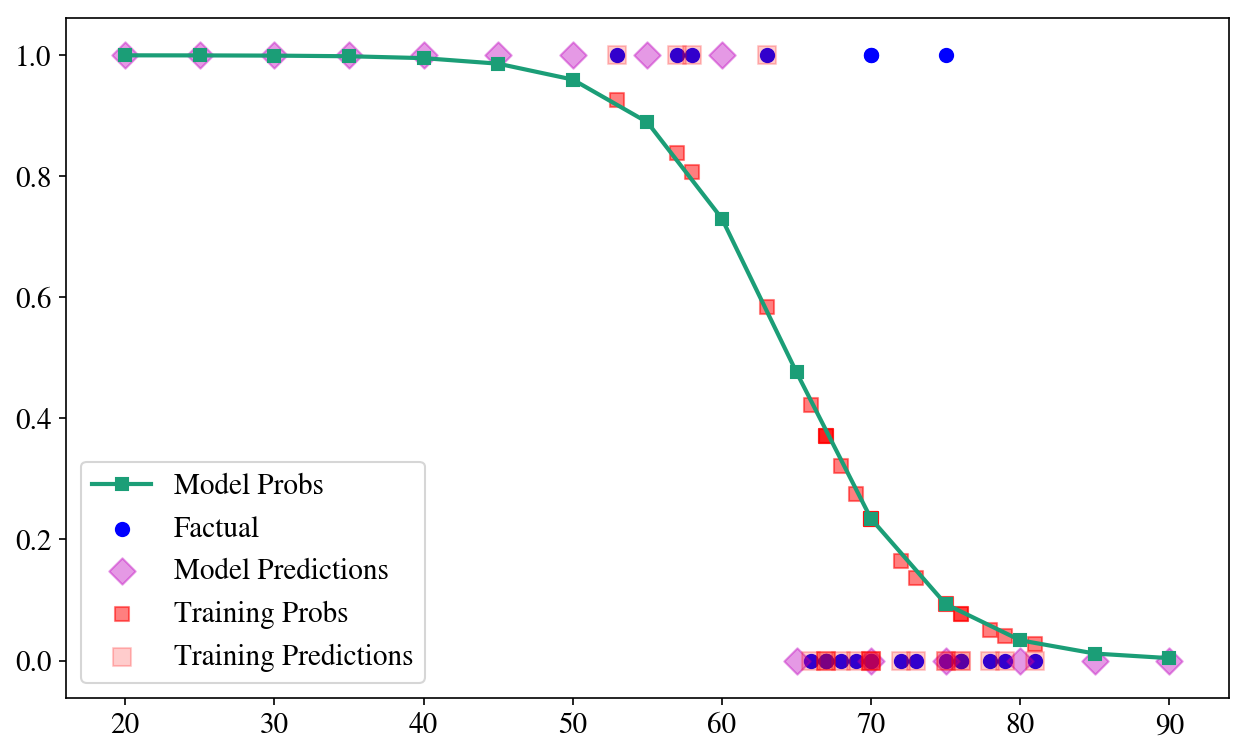

In [31]:
plt.scatter(temps, pfail, s=40, 
           c='b', label='Factual')
# create new temp data set to expose the model variance
tempsnew=np.linspace(20., 90., 15)

probs=clf.predict_proba(tempsnew.reshape(-1,1))[:,1]
predicts=clf.predict(tempsnew.reshape(-1,1))

plt.plot(tempsnew, probs, marker='s', label='Model Probs')

plt.scatter(tempsnew, predicts, 
            marker='D', color="m", 
            s=80, alpha=0.4, label='Model Predictions')

train_probs=clf.predict_proba(temps.reshape(-1,1))[:,1]

plt.scatter(temps, train_probs, 
            marker='s', c='r', 
            alpha=0.5, s=40, label='Training Probs')

train_predicts=clf.predict(temps.reshape(-1,1))
plt.scatter(temps, train_predicts, 
            marker='s', c='r', 
            alpha=0.2, s=80 , label='Training Predictions')

plt.legend(loc='lower left')

---